In [ ]:
import numpy as np
from scipy.linalg import sqrtm, inv

In [ ]:
def get_synthetic_data(n, d, r, scale):
  '''
  return:
  X of shape (n, d)
  Y of shape (n,)
  UZ of shape (d, r)
  Sigma of shape (d, d)
  '''

  UZ = np.random.randn(d, r)
  s1 = np.diag((np.arange(r, 0, -1))**scale)
  SigmaZ = UZ @ s1 @ UZ.T

  SigmaX = np.eye(d)
  X = np.random.randn(n, d) @ np.sqrt(SigmaX)
  Y = np.sum((X @ SigmaZ) * X, axis=1)

  return X, Y, UZ, SigmaZ, s1

In [ ]:
def bwgd(X, Y, r, iter, U0, Uz, lambd=0.0, iter_with_reg=0, reg='entropy', delta=0.001):
    """
    Computes the BWGD.

    """
    n, d = X.shape
    CX = X.T @ X / n # = C_n
    CXsqrt = sqrtm(CX) # C_n^(1/2)
    CXsqrtinv = inv(CXsqrt) # C_n^(-1/2)
    X2 = X @ CXsqrtinv # X2[i] = x_i.T @ C_n^(-1/2)

    bary = U0
    dists = np.zeros(iter)
    YX = Y[:, None] * X2 # YX[i] = y_i * x_i.T @ C_n^(-1/2)

    err_diff = 1.0
    times = np.zeros(iter)
    import time
    start_time = time.time()
    for i in range(iter):
        step = 0.9
        denoms = np.linalg.norm(YX @ bary, 2, axis=1)
        bary = (1.0/n) * (step) * YX.T @ ((YX @ bary) / denoms[:, None]) + (1.0-step) * bary
        if (lambd != 0.0) and (i < iter_with_reg):
          if reg == 'entropy':
            bary += step * lambd * inv(bary @ bary.T + delta * np.eye(d)) @ bary
          if reg == 'L2':
            bary += - step * lambd * bary @ bary.T @ bary


        Ub = CXsqrtinv @ bary
        if Ub.shape[1] != Uz.shape[1]:
            dists[i] = np.linalg.norm(sqrtm(Ub @ Ub.T) - sqrtm(Uz @ Uz.T), 'fro')
        else:
            u, _, v = np.linalg.svd(Uz.T @ Ub)
            dists[i] = np.linalg.norm(u @ (v @ Ub.T) - Uz.T, 'fro')

        times[i] = time.time() - start_time

    barys = CXsqrtinv @ bary @ bary.T @ CXsqrtinv
    bary = CXsqrtinv @ bary

    return barys, dists, bary, times

In [ ]:
d = 32                      # X shape (n, d)
r_list = [2, 4, 16]         # Sigma rank
scales = [0, 1, 2]          # scale for Sigma matrix
n_coefs = [3, 10, 20]

r = 4
scale = 1
n_coef = 1
n = n_coef * d * r - 20
print(n)

108


In [ ]:
X, Y, UZ, Sigma_true, s1 = get_synthetic_data(n, d, r, scale)
U0 = 1 * np.random.randn(d, r)
U0FR = 1 * np.random.randn(d, d)

In [ ]:
import matplotlib.pyplot as plt

135.54364070291453
148.5591319241461
134.05028713636267


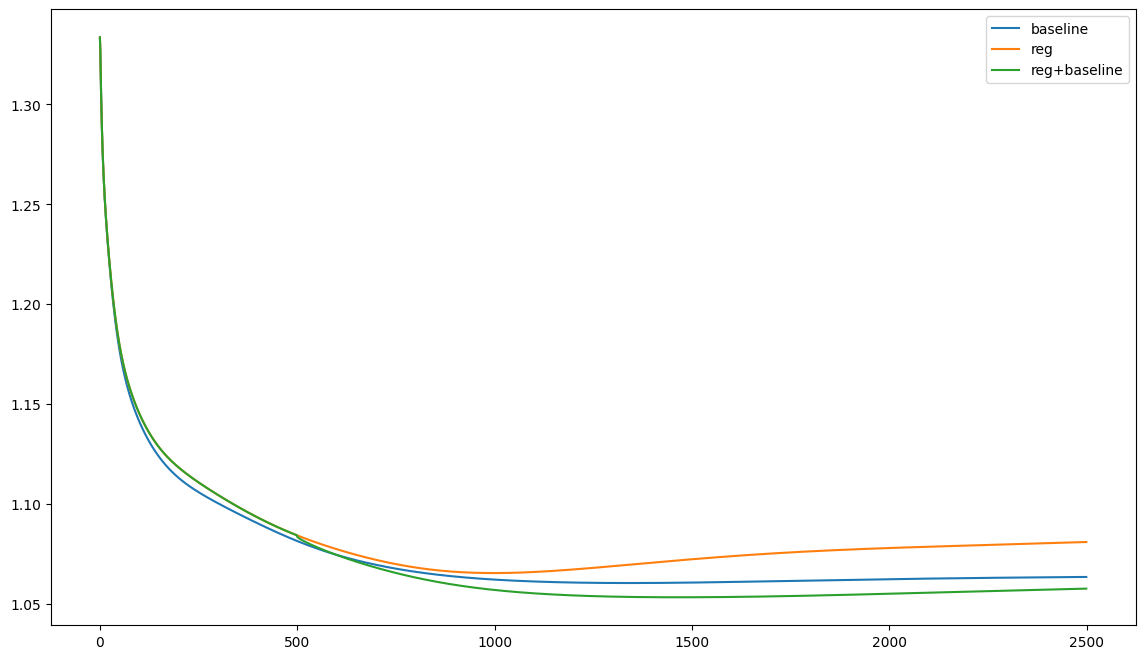

In [ ]:
lambd = 0.1 * 2

fig = plt.figure(figsize=(14, 8))
barys, dists, bary, times = bwgd(X, Y**0.5, r, 2500, U0.copy(), UZ.copy() @ (s1**0.5))
print(np.linalg.norm(barys - Sigma_true, 'fro'))
plt.plot(np.log10(dists), label="baseline")
barys, dists, bary, times = bwgd(X, Y**0.5, r, 2500, U0.copy(), UZ.copy() @ (s1**0.5), lambd, 10000, "entropy")
print(np.linalg.norm(barys - Sigma_true, 'fro'))
plt.plot(np.log10(dists), label="reg")
barys, dists, bary, times = bwgd(X, Y**0.5, r, 2500, U0.copy(), UZ.copy() @ (s1**0.5), lambd, 500, "entropy")
print(np.linalg.norm(barys - Sigma_true, 'fro'))
plt.plot(np.log10(dists), label="reg+baseline")

'''
barys, dists, bary, times = bwgd(X, Y**0.5, r, 2500, 1 * np.random.randn(d, r), UZ.copy() @ (s1**0.5))
plt.plot(np.log10(dists), label="baseline2", color='r')
barys, dists, bary, times = bwgd(X, Y**0.5, r, 2500, 1 * np.random.randn(d, r), UZ.copy() @ (s1**0.5))
plt.plot(np.log10(dists), label="baseline2", color='r')
barys, dists, bary, times = bwgd(X, Y**0.5, r, 2500, 1 * np.random.randn(d, r), UZ.copy() @ (s1**0.5))
plt.plot(np.log10(dists), label="baseline2", color='r')
'''
plt.legend()
plt.show()

In [ ]:
X = np.array([[1, 0], [0, 1], [1, 1]])
Y = np.array([1, 2, 3])
r = 10
iter = 3
U0 = np.ones((2, 2))
Uz = np.ones((2, 2))

In [ ]:
bwgd(X, Y, r, iter, U0, Uz)

[[1 1]
 [2 2]
 [3 3]]
(3, 2)


(array([[1., 2.],
        [2., 4.]]),
 array([0.71743894, 0.71743894, 0.71743894]),
 array([[0.70710678, 0.70710678],
        [1.41421356, 1.41421356]]),
 array([0.00027776, 0.00041509, 0.00052333]))